In [1]:
import matplotlib.pyplot as plt
import tensorflow
import numpy as np
from ssqueezepy import cwt, ssq_cwt, Wavelet
from ssqueezepy.utils import make_scales, cwt_scalebounds
from ssqueezepy.experimental import scale_to_freq
from ssqueezepy.visuals import plot, imshow
import torch
from MyEDFImports import load_all_data, load_all_labels, three_stages_transform, stages_names, stages_names_3_outputs

2023-06-13 11:38:34.462722: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 11:38:34.504630: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-13 11:38:34.505063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 11:38:35.091317: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = load_all_data()
one_instance = data[3000]
coef, scale_auto = cwt(one_instance, wavelet='morlet')
plt.imshow(np.abs(coef), aspect='auto', cmap='turbo')

Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/CP229110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:39: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/WD224010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/TK221110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/VP214110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_

/home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/MyEDFImports.py:39: RuntimeWarning: Channel names are not unique, found duplicates for: {'CHIN EMG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(path + "//" + name)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/LM230010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/VC209100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_states/Jean-Pol_repaired_headers/LA216100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from /home/tadeusz/Desktop/Tadeusz/mgr_sleep_

Making min and max xcale somewhat sensible with sqquezepy

In [4]:
len_signal = len(one_instance)
wavelet = Wavelet('morlet')
# scale boundaries
min_scale, max_scale = cwt_scalebounds(wavelet, len_signal)
scales = make_scales(len_signal, scaletype='log', min_scale=min_scale, max_scale=max_scale)

3.9142883 16742.764 3.890701738824473 4658.854795600471


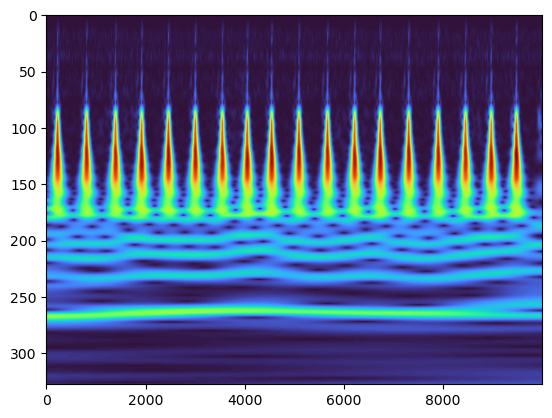

In [5]:
print(scale_auto[1], scale_auto[-1], min_scale, max_scale)
coef, *_ = cwt(one_instance, wavelet='morlet', scales=scales)
plt.imshow(np.abs(coef), aspect='auto', cmap='turbo')

In [6]:
labels = load_all_labels()
labels_3_stages = three_stages_transform(labels)
from collections import Counter

counted_labels_3_stages = Counter(labels_3_stages)

Choosing three random samples from different labels

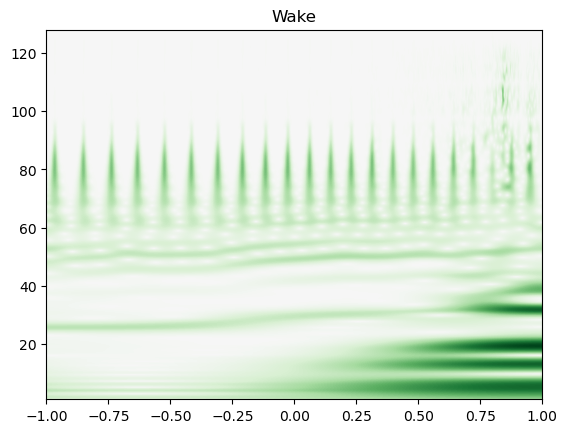

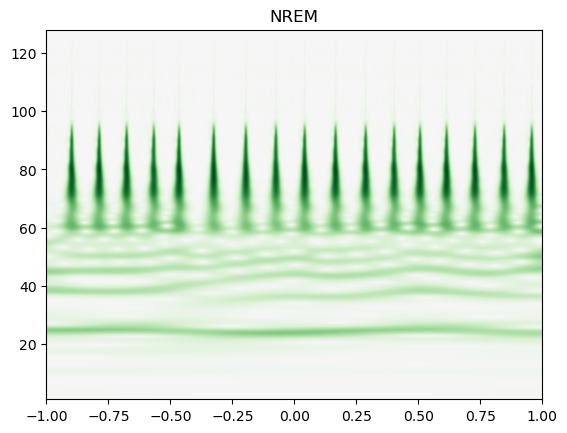

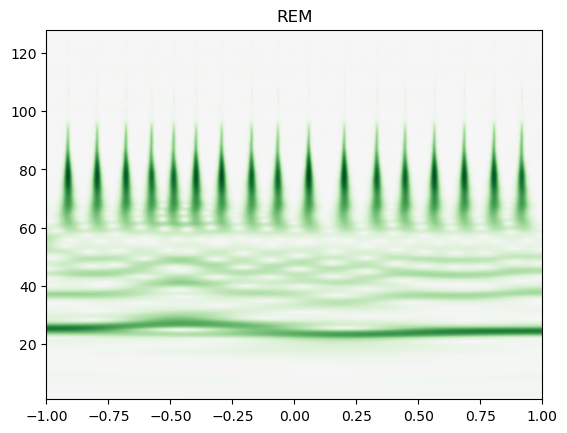

In [7]:
for key in counted_labels_3_stages.keys():
    random_ind = np.random.choice(np.where(labels == key)[0])
    random_slice = data[random_ind]
    coef, freq = cwt(random_slice, wavelet='morlet', scales=scales)
    plt.imshow(np.abs(coef), extent=[-1, 1, 1, 128], cmap='PRGn', aspect='auto',
               vmax=abs(coef).max(), vmin=-abs(coef).max(), label=key)
    plt.title(stages_names_3_outputs[key])
    plt.show()

## we should reshape it into 224x224 and save those LOCALLY

import torchvision.transforms as T

images = np.empty(shape=(len(data), 224, 224))
for i, datapoint in enumerate(data):
    if i % 1000 == 0:
        print(i)
    coef, freq = cwt(datapoint, wavelet='morlet', scales=scales)
    abs_coef = np.abs(coef)
    torch_tensor = torch.from_numpy(abs_coef)
    # 10000 maybe not hard coded but taken from length of signal
    reshaped_torch_tensor = torch.reshape(torch_tensor, (1, 1, -1, 10000))
    resized_image_4d = T.Resize((224, 224))(reshaped_torch_tensor)
    resized_image_2d = torch.squeeze(resized_image_4d)

    images[i] = resized_image_2d
np.save(f'images_{images.shape}_wav_morlet_sqpy', images)

In [8]:
images = np.load('images_(19248, 224, 224)_wav_morlet_sqpy.npy')
images = [(image,image,image) for image in images]
labels = labels_3_stages
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_train, X_test, y_train, y_test = np.asarray(X_train), np.asarray(X_test), np.asarray(y_train), np.asarray(y_test)



In [ ]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False
base_model.summary()

2023-06-13 09:44:01.839178: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 09:44:01.842988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 09:44:01.843145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es], verbose=1)
